# Bayesian Data Analysis Project: U.S. Births
### DTU, 2018
### Team Members: Inon Peled, Niklas Christopher Petersen, Mads Paulsen. 

# Introduction
TODO: The introduction is inviting, presents an overview of the notebook. Information is relevant and presented in a logical order. The notebook presents a clear cohesive data analysis story, which is enjoyable to read. Structure and organization. What is the data and the analysis problem.

The model can be something already used in the course or something else, but don’t try to do
too complex things. Ther are separate project courses work for more complex models. So mention similarity to some homework models.

### Imports and Commonly Used Symbols

In [74]:
import gzip
import pickle
import matplotlib
import os
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import pystan
from matplotlib.ticker import MultipleLocator
from scipy.stats import gaussian_kde
import numpy as np
from datetime import datetime, timedelta
import warnings
import time
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
rcParams['figure.figsize'] = 16, 6
COMMON_SEED = 1234

def check_convergence(fit, also_print=False):
    report = print if also_print else lambda x: None
    
    def all_rhat_small_enough(fit):
        return all(dict(fit.summary())['summary'][:, -1] < 1.1)
    
    def max_treedepth_exceeded(fit, max_depth = 10):
        """Check transitions that ended prematurely due to maximum tree depth limit"""
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        depths = [x for y in sampler_params for x in y['treedepth__']]
        n = sum(1 for x in depths if x == max_depth)
        if n > 0:
            report('Run again with max_depth set to a larger value to avoid saturation')        
        N = len(depths)
        report(('{} of {} iterations saturated the maximum tree depth of {}'
               + ' ({}%)').format(n, N, max_depth, 100 * n / N))
        return float(n) / N
    
    def e_bfmi_all_low_enough(fit):
        """
        Checks the energy Bayesian fraction of missing information (E-BFMI).
        E-BFMI below 0.2 indicates you may need to reparameterize your model
        """
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        for chain_num, s in enumerate(sampler_params):
            energies = s['energy__']
            numer = sum((energies[i] - energies[i - 1])**2 for i in range(1, len(energies))) / len(energies)
            denom = np.var(energies)
            if numer / denom < 0.2:
                report('Chain {}: E-BFMI = {}'.format(chain_num, numer / denom))
                report('E-BFMI below 0.2 indicates you may need to reparameterize your model')
                return False
        return True

    def fraction_of_transitions_which_ended_with_divergence(fit):
        """Check transitions that ended with a divergence"""
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        divergent = [x for y in sampler_params for x in y['divergent__']]
        n = sum(divergent)
        N = len(divergent)
        report('{} of {} iterations ended with a divergence ({}%)'
              .format(n, N, 100 * n / N))
        if n > 0:
            report('Try running with larger adapt_delta to remove the divergences')
        return n / N
    
    assert all_rhat_small_enough(fit)
    assert max_treedepth_exceeded(fit) < 0.02
    assert e_bfmi_all_low_enough(fit)
    assert fraction_of_transitions_which_ended_with_divergence(fit) == 0
    report("##### All convergence checks passed successfully. #####")

# Data Description

Before fitting prediction models, let us look into the data we have.

In [3]:
births_2000s_df = pd.read_csv('US_births_2000-2014_SSA.csv')
births_2000s_df_with_index = births_2000s_df\
    .rename(columns={'date_of_month': 'day'})\
    .set_index(pd.to_datetime(
        births_2000s_df.rename(columns={'date_of_month': 'day'})
        [['year', 'month', 'day']]))\
    .assign(weekday_name=lambda df: df.index.weekday_name)\
    .assign(day_of_year=lambda df: df.index.dayofyear)\
    .assign(week_of_year=lambda df: df.index.weekofyear)
births_2000s_df_with_index.tail()

,year,month,day,day_of_week,births,weekday_name,day_of_year,week_of_year
2014-12-27,2014,12,27,6,8656,Saturday,361,52
2014-12-28,2014,12,28,7,7724,Sunday,362,52
2014-12-29,2014,12,29,1,12811,Monday,363,1
2014-12-30,2014,12,30,2,13634,Tuesday,364,1
2014-12-31,2014,12,31,3,11990,Wednesday,365,1


We assert that no data imputation is needed.

In [4]:
def num_days_in_year(year):
    return (datetime(year, 12, 31) - datetime(year, 1, 1)).days + 1


def missing_days(df):
    return births_2000s_df_with_index.groupby('year').births.describe()\
        .assign(expected_days=lambda df: list(map(num_days_in_year, df.index)))\
        .assign(missing=lambda df: df.expected_days - df['count'])

        
assert not any(missing_days(births_2000s_df_with_index).missing)

### Distribution Statistics

We next show how births distribute in each year, month, and day of week. We see that whereas the data follows a somewhat steady mean and std. dev. over years and over months, there are is much more variability between days of week:
1. There are numerous outliers in each day of week.
2. There are significantly _less_ births during the weekend (Saturday-Sunday) than during the work week (Monday-Friday).
3. Weekend days have lower variance than work days.

In [5]:
# def show_mean_and_std_by_time_dimension(time_dimension):
#     births_2000s_df_with_index.groupby(time_dimension).births.describe()[['mean', 'std']].plot.bar(fontsize=14)

# list(map(show_mean_and_std_by_time_dimension, ['weekday_name', 'year', 'month']));

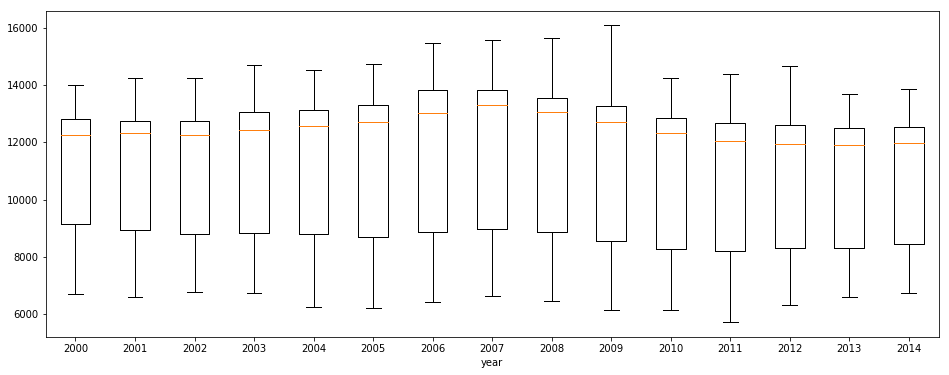

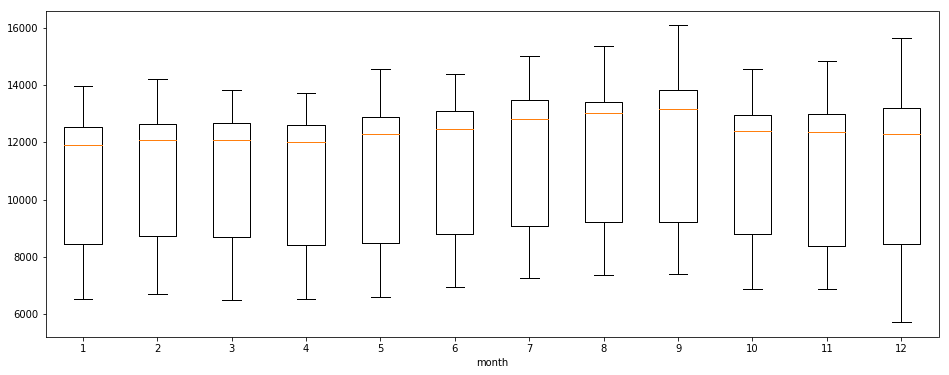

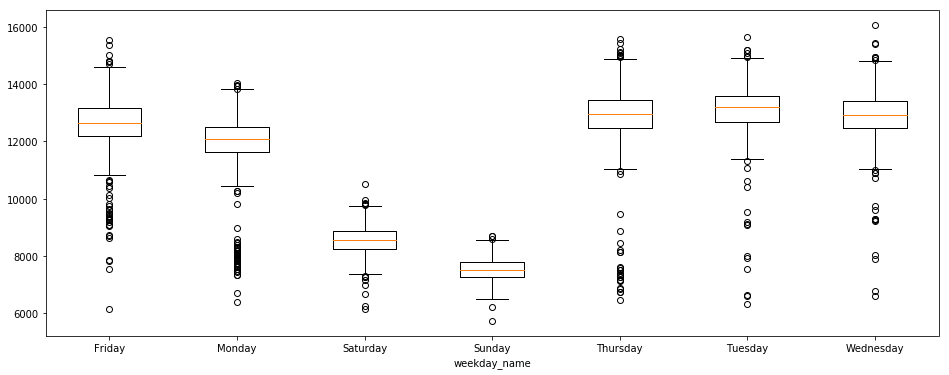

In [6]:
def boxplots(df, time_dimension):
    fig, ax = plt.subplots(1, 1)
    x = sorted(df[time_dimension].unique())
    ax.boxplot([list(df[df[time_dimension] == t].births) for t in x])
    ax.set_xticklabels(x)
    ax.set_xlabel(df[time_dimension].name)

    
for time_dimension in ('year', 'month', 'weekday_name'):
    boxplots(births_2000s_df_with_index, time_dimension)

We also take a look at the distribution of all data points, regardless of time. The distribution is markedly bimodal: one mode for weekend, the other for rest of week. In fact, the weekend distribution is bimodal too, because of differences between Saturday and Sunday.

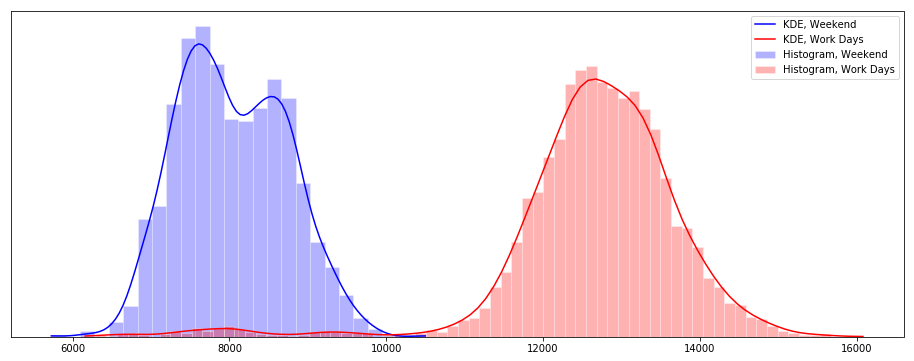

In [7]:
def density_estimation(df):
    fig, ax = plt.subplots(1, 1)
    births_weekend = df.births[df.day_of_week >= 6]
    births_work_days = df.births[df.day_of_week < 6]
    
    ax.hist(births_weekend, bins='auto', facecolor='blue', edgecolor='white', 
            normed=True, label="Histogram, Weekend", alpha=0.3)
    ax.hist(births_work_days, bins='auto', facecolor='red', edgecolor='white', 
            normed=True, label="Histogram, Work Days", alpha=0.3)

    x_kde_weekend = np.linspace(births_weekend.min(), births_weekend.max(), 100)
    ax.plot(x_kde_weekend, gaussian_kde(births_weekend)(x_kde_weekend),
            label="KDE, Weekend", color='blue')

    x_kde_work_days = np.linspace(births_work_days.min(), births_work_days.max(), 100)
    ax.plot(x_kde_work_days, gaussian_kde(births_work_days)(x_kde_work_days), label="KDE, Work Days", color='red')
    
    ax.get_yaxis().set_visible(False)
    ax.legend()
    
density_estimation(births_2000s_df_with_index)

Finally, we turn to look at Gaussian Kernel Density Estimation (KDE) for each weekday separately.

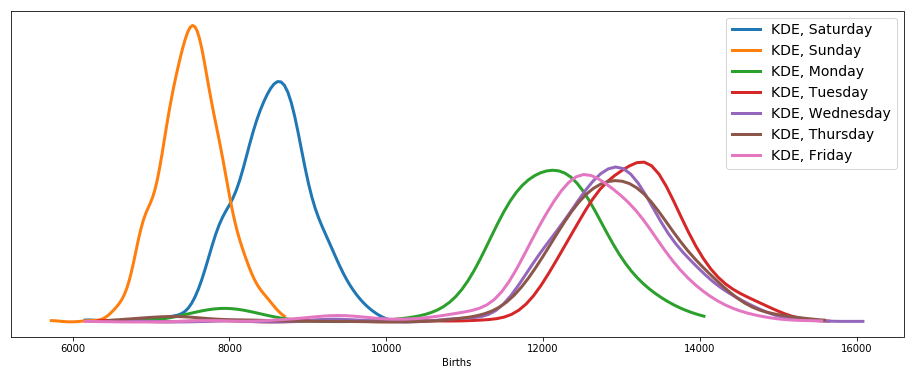

In [8]:
def density_estimation_by_weekday(df):
    fig, ax = plt.subplots(1, 1)
    for d in df.weekday_name.unique():
        daily_births = df.births[df.weekday_name == d]
        x_kde = np.linspace(daily_births.min(), daily_births.max(), 100)
        ax.plot(x_kde, gaussian_kde(daily_births)(x_kde), label="KDE, %s" % d, lw=3)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Births")
    ax.legend(fontsize=14)
    
density_estimation_by_weekday(births_2000s_df_with_index)

## Seasonality
The next few plots are meant to emphasize any obvious seasonality in the time series of births.

First, we see that each year displays are generally similar trend: steady increase in first few months, followed by a peak, a drop, and another peak at end of year.

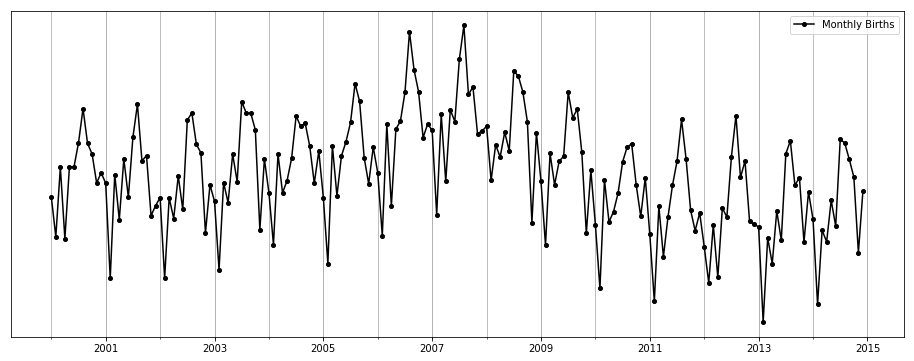

In [9]:
def plot_monthly_births(df):
    d = df.groupby(('year', 'month')).births.sum().reset_index()
    f = pd.to_datetime(d.assign(day=1).drop('births', axis=1))
    ax = d.set_index(f).drop(['year', 'month'], axis=1)\
        .births.rename("Monthly Births")\
        .plot(color="black", marker='o', markersize=4)
    ax.legend()
    ax.grid(which='both')
    ax.get_yaxis().set_visible(False)

plot_monthly_births(births_2000s_df_with_index)

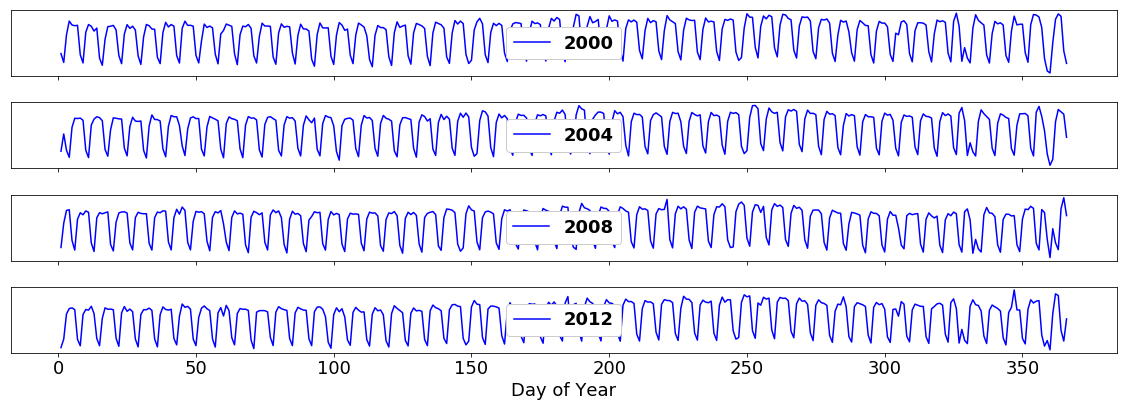

In [10]:
def compare_some_years(years):
    matplotlib.rc('font', **{'size': 18})
    fix, axes = plt.subplots(len(years), 1, sharex=True)
    for i, year in enumerate(years):
        axes[i].plot(
            births_2000s_df_with_index.set_index('day_of_year')[lambda r: r.year == year].births, 
            label=year, color='blue')
        axes[i].legend(prop={'weight':'bold'}, loc='center', framealpha=1)
        axes[i].get_yaxis().set_visible(False)
    axes[-1].set_xlabel("Day of Year")
    plt.tight_layout()
        
compare_some_years(range(2000, 2015, 4))

It is known that people are biased against giving births in some specific dates: holidays, 13th of each month, and 29th Feb. on leap years. However, in this work, we will not involve any contextual information, but rather use only the births data.

# Bayesian Inference Models and Priors

The following describes each Bayesian Inference model we test, along with justifications for choosing such a model, and a definition of the **prior distributions** which the model uses. All models work on standardized data, i.e. for each data point in a train set, we remove the train set mean and then divide by the train set std. dev.

### Models Disregarding the Time Series
The plot of KDEs shows that for each weekday, the data distribution resembles a Gaussian. We should thus try several models:
1. Searate Model: for each weekday $d=1..7$, assign parameters $\mu_d, \sigma_d>0$, each with prior $\mathcal{N}(0, 10)$, and let $y_n \sim \mathcal{N} \left( \mu_{x_n}, \sigma_{x_n}^2 \right)$, where $x_n$ is day-of-week.
2. Hierarchical Model: similar to Separate Model, except that all $\mu_d$ and all $\sigma_d$ are each drawn from a shared distribution.
3. Hierarchicial Model for work days, Separate Models for weekend days.

### Models Using the Time Series
1. For each day $t$, let
$$
x_t = \left( \text{year}_t, \text{month}_t, \text{day-of-month}_t, \text{day-of-week}_t \right)
$$
We model the number of births $y_t$ as following a prior Poisson distribution, with rate determined by data in days up to $t-1$, namely
$$
y_t \sim Poisson \left( exp\left(z_t\right) \right)
$$
where the exponent ensures that the Poisson rate is positive, and
$$
z_t \sim \mathcal{N}\left(\mu_t, \sigma_t^2\right)
$$
so that 
$$
\mu_t = \beta_\mu z_{t-1} + \theta_\mu^T x_t \\
\sigma_t = \beta_\sigma z_{t-1} + \theta_\sigma^T x_t
$$
The parameters to be learnt are $\beta_\mu, \beta_\sigma, \theta_mu, \theta_\sigma$, each with prior $\mathcal{N}(0, 10)$. In accordance with our data analysis, this model is heteroskedastic, i.e. allows a different variance $\sigma_t$ for each $t$.

2. Same as the former option, except that
$$
y_t \sim NB \left( r, \frac{exp(z_t)}{exp(z_t) + r} \right)
$$
Where NB is the Negative Binomial distribution, and $r$ is another parameter to be learnt. The Negative Binomial distribution allows for variance different than mean, and so is more robust than the Poisson distribution, where the mean and variance are the same.

TODO: Required onvergence diagnostic results (Rhat, neff, divergences) shown and maning of the results is discussed.
TODO: PGM drawings from e.g. ShinyStan?
TODO: A table summarizing the Stan parameters (chains, algorithm, etc.) we use in running each model.

# Models for Weekdays

## Separate Model
In the separate model, each weekday $j$ is given an independent prior $\text{Cauchy}(\mu_j, \sigma_j)$, where $\mu_j$ equal to the sample mean and $\sigma_j$ equal to the sample standard deviation for weekday $j$. We choose the Cauchy distribution because it

In [11]:
model_separate_weekdays = pystan.StanModel(model_code='''
data {
    int<lower=0> K;
    int<lower=0> N; // Number of data points.
    vector[N] y; // data points.
    int<lower=1,upper=K> x[N]; // Weekday indicator for each data point.
}
parameters {
    real<lower=0> mu[K];    // Separate means.
    real<lower=0> sigma[K]; // Separate std. devs.
}
model {
    mu ~ cauchy(0, 10);
    sigma ~ cauchy(0, 5); // Half-Cauchy, because of non-negativity constraint.
    y ~ normal(mu[x], sigma[x]);
}
''')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b9a29008c16ff78135c317634b59900 NOW.


In [12]:
x = births_2000s_df_with_index.day_of_week.values
y = births_2000s_df_with_index.births.values
N = len(y)
print(x, y, N, sep='\n')

[6 7 1 ... 1 2 3]
[ 9083  8006 11363 ... 12811 13634 11990]
5479


In [13]:
def detrend_by_weekday(x, y):
    x_zero_based = x - 1
    means = np.empty(7)
    std_devs = np.empty(7)
    y_detrended = np.empty(len(y))
    for j in range(7):
        means[j] = y[x_zero_based == j].mean()
        std_devs[j] = y[x_zero_based == j].std()
        y_detrended[x_zero_based == j] = (y[x_zero_based == j] - means[j]) / std_devs[j]
    return y_detrended, means, std_devs

y_detrended_by_weekdays, y_means, y_stds = detrend_by_weekday(x, y)
print(y_detrended_by_weekdays, y_means, y_stds, sep='\n')

[ 1.04393186  1.21999946 -0.45766158 ...  0.78141213  0.56473665
 -1.03462411]
[11897.83014049 13122.44444444 12910.76628352 12845.82608696
 12596.16240409  8562.5734355   7518.37675607]
[1168.61489899  905.83027213  889.95247066 1173.60086059  985.00009761
  498.52541631  399.69135899]


In [102]:
def get_train_and_test_for_sliding_window(test_date):
    num_data_points_before_first_test_date = datetime(2014, 1, 1) - datetime(2001, 1, 1)
    df = births_2000s_df_with_index[['day_of_week', 'births']]\
        [lambda df: df.index <= test_date + timedelta(days=6)]\
        [lambda df: df.index >= test_date - num_data_points_before_first_test_date]
    return {
        'x_train': df.index[:-7],
        'y_train': df.births[:-7].values,
        'x_test': df.index[-7:],
        'y_test': df.births[-7:].values
    }
        
get_train_and_test_for_sliding_window(datetime(2014, 1, 1))

{'x_test': DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
                '2014-01-05', '2014-01-06', '2014-01-07'],
               dtype='datetime64[ns]', freq=None),
 'x_train': DatetimeIndex(['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-04',
                '2001-01-05', '2001-01-06', '2001-01-07', '2001-01-08',
                '2001-01-09', '2001-01-10',
                ...
                '2013-12-22', '2013-12-23', '2013-12-24', '2013-12-25',
                '2013-12-26', '2013-12-27', '2013-12-28', '2013-12-29',
                '2013-12-30', '2013-12-31'],
               dtype='datetime64[ns]', length=4748, freq=None),
 'y_test': array([ 8018, 11171, 12317,  8199,  7174, 11400, 12310], dtype=int64),
 'y_train': array([ 7663, 10635, 12449, ...,  7896, 13096, 12525], dtype=int64)}

In [99]:
def fit_sliding_window(model, data, **kwargs_for_fitting):
    # TODO: sample from predictive distribution.
    for i in range(1):
        data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=i))
        x = data['x_train']
        y_detrended, y_mean, y_std = detrend_by_weekday(data['x_train'], data['y_train'])
        fit = model.sampling(seed=COMMON_SEED, data=dict(
            x=x,
            y=y_detrended, 
            K=7,
            N=len(x)
        ), **dict(iter=500))
        check_convergence(fit)
    
fit_sliding_window(
    model=model_separate_weekdays, 
    data=dict(K=7, N=N, x=x, y=y_detrended_by_weekdays));

In [16]:
def rmse(prediction_errors):
    return (prediction_errors ** 2).mean() ** 0.5


# Predictive Performance Assessment
RMSE, MAE, widht of 95% C.I.
Cross-Validation?

# Discussion of Potential Improvements
Discussion of problems and potential improvements:
* Use contextual information, which is known to account for trends in the data.
* Compare to some classic baseline models for time series prediction, e.g. Seasonal ARIMA with exogenous variables.
* More sensitivity analysis for choice of prior. 

# Conclusion
In particular, emphasize one main conclusion.

## ARIMA model

In [18]:
from statsmodels.tsa.arima_model import ARIMA

In [19]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure()
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

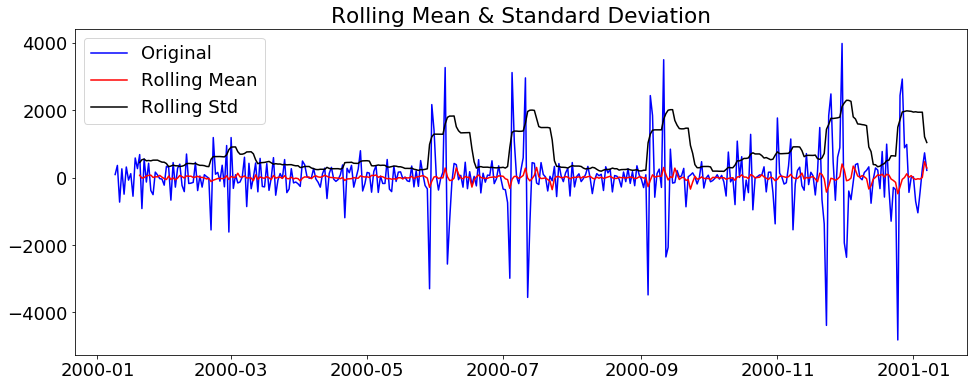

Results of Dickey-Fuller Test:
Test Statistic                -9.259992e+00
p-value                        1.415581e-15
#Lags Used                     1.600000e+01
Number of Observations Used    3.480000e+02
Critical Value (1%)           -3.449282e+00
Critical Value (5%)           -2.869881e+00
Critical Value (10%)          -2.571214e+00
dtype: float64


In [20]:
test_stationarity(df['births'].diff(1).diff(7).dropna()[:365])

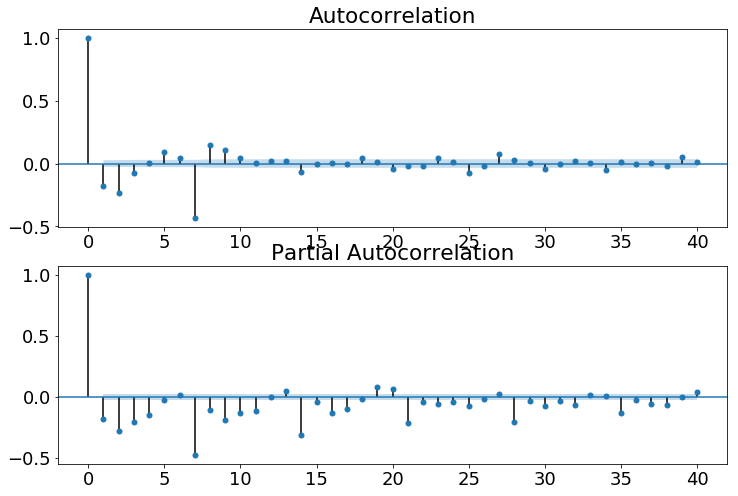

In [21]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['births'].diff(1).diff(7)[8:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['births'].diff(1).diff(7)[8:], lags=40, ax=ax2)
plt.show()

In [125]:
model_arima = pystan.StanModel(model_code='''
data {
  int<lower=1> N;           // number of observations used for fit
  int<lower=1> P;           // number of time lags of the autoregressive model
  int<lower=1> K;           // number of predictions
  real y[N+K];              // observed outputs
  
  // priors
  real mu_prior_location;
  real mu_prior_scale;

  real sigma_prior_location;
  real sigma_prior_scale;
}
parameters {
  real mu;                  // mean term
  vector[P] phi;            // autoregression coeff for P lags 
  real theta;               // moving avg coeff for lag 1
  real<lower=0> sigma;      // noise scale
}
model {
  vector[N] nu;             // prediction for time t
  vector[N] err;            // error for time t
  
  // Burn in for y[1..K], e.g. assume lags of y = mu, and err = 0
  for (t in 1:K) {
    nu[t] = mu;
    for (p in 1:P) {
      nu[t] = nu[t] + phi[p] * mu;
    }
    err[t] = y[t] - nu[t];
  }
  
  // Fit for y[K+1..N]
  for (t in K + 1:N) {
    nu[t] = mu;
    for (p in 1:P) {
      nu[t] = nu[t] + phi[p] * y[t - p];
    }
    nu[t] = nu[t] + theta * err[t - 1];
    err[t] = y[t] - nu[t];
  }

  // priors
  mu ~ normal(mu_prior_location, mu_prior_scale);
  phi ~ normal(0, 2);
  theta ~ normal(0, 2);
  sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);

  // likelihood
  err ~ normal(0, sigma);
}
generated quantities {
    vector[2*K] y_pred;
    vector[2*K] nu;
    vector[2*K] err;
        
    real loglik;
    
    // Copy the last K values onto new vector, and calculate the err
    for (t in 1:K) {
        y_pred[t] = y[N - K + t];
        nu[t] = mu;
        for (p in 1:P) {
          nu[t] = nu[t] + phi[p] * y[N - K + t - p];
        }
        err[t] = y_pred[t] - nu[t];
    }
    
    // Predictions for the next K time steps.
    for (t in K + 1:2*K) {
        nu[t] = mu;
        for (p in 1:P) {
          nu[t] = nu[t] + phi[p] * y[t - p];
        }
        nu[t] = nu[t] + theta * err[t - 1];
        err[t] = err[t - 1]; // Keep error term, as we don't know the error.
        
        y_pred[t] = normal_rng(nu[t], sigma);        
        
        loglik += normal_lpdf(y[N - K + t] | nu[t], sigma);
    }
}
''')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2eb87736f42ffaeef87c8ec07db5ff36 NOW.


In [71]:
def arima_priors_by_year_2000():
    df_2000 = births_2000s_df_with_index[lambda df: df.year == 2000]
    return df_2000.agg(['mean', 'std']).births

In [ ]:
def arima_fit_separate_sliding_windows(persist_path, num_windows):
    if not os.path.exists(persist_path):
        os.mkdir(persist_path)
    all_prediction_errors = []
    priors = arima_priors_by_year_2000()
    for i in range(num_windows):
        #if os.path.exists(os.path.join(persist_path, 'fit%d_summary.pkl.gz' % i)):
        #    continue
        data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=i * 7))
        fit = model_arima.sampling(seed=COMMON_SEED, data={
            'mu_prior_location': priors['mean'],
            'mu_prior_scale': 4 * priors['std'],
            'sigma_prior_location': priors['std'],
            'sigma_prior_scale': .5 * priors['std'],            
            'N': len(data['y_train']),
            'P': 7,
            'K': len(data['y_test']),
            'y': np.concatenate([data['y_train'], data['y_test']])
        }, iter=500)
        y_pred = fit.extract()['y_pred'][:,-7:]
        pred_err = y_pred.mean(axis=0) - data['y_test']
        all_prediction_errors.append(pred_err)
        with gzip.open(os.path.join(persist_path, 'fit%d_summary.pkl.gz' % i), 'wb') as f:
            pickle.dump(fit.summary(), f)
        with gzip.open(os.path.join(persist_path, 'fit%d_extract.pkl.gz' % i), 'wb') as f:
            pickle.dump(fit.extract(), f)         
        with gzip.open(os.path.join(persist_path, 'fit%d_pred_err.pkl.gz' % i), 'wb') as f:
            pickle.dump(pred_err, f)        

arima_fit_separate_sliding_windows(persist_path = 'fit_arima', num_windows = 52)

In [83]:
def arima_evaluate_separate_sliding_windows(persist_path, num_windows):
    all_prediction_errors = []
    for i in range(num_windows):
        with gzip.open(os.path.join(persist_path, 'fit%d_pred_err.pkl.gz' % i), 'rb') as f:
            pred_err = pickle.load(f)  
            all_prediction_errors.append(pred_err)
    return rmse(np.concatenate(all_prediction_errors))

arima_evaluate_separate_sliding_windows('fit_arima', 52)

3183.485881533312

### Using Statsmodels ARIMA

In [120]:
def statmodels_arima_fit_separate_sliding_windows(persist_path, num_windows):
    if not os.path.exists(persist_path):
        os.mkdir(persist_path)
    all_prediction_errors = []
    priors = arima_priors_by_year_2000()
    for i in range(num_windows):
        if os.path.exists(os.path.join(persist_path, 'fit%d_summary.pkl.gz' % i)):
            continue
        data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=i * 7))
        data_train = pd.Series(index = data['x_train'], data = data['y_train'].astype(float))
        data_test = pd.Series(index = data['x_test'], data = data['y_test'].astype(float))
        order = (7, 0, 1)
        model = ARIMA(data_train, order, freq='D')
        model = model.fit()
        y_pred = model.predict(len(data_train), len(data_train) + len(data_test) - 1)
        pred_err = y_pred - data['y_test']
        all_prediction_errors.append(pred_err)     
        with gzip.open(os.path.join(persist_path, 'fit%d_pred_err.pkl.gz' % i), 'wb') as f:
            pickle.dump(pred_err, f)        

statmodels_arima_fit_separate_sliding_windows(persist_path = 'fit_arima_statmodels', num_windows = 52)

In [121]:
arima_evaluate_separate_sliding_windows('fit_arima_statmodels', 52)

861.5200063770038

## Using prophet

In [26]:
from fbprophet import Prophet

In [27]:
m = Prophet()
m.fit(df_train);

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
forecast = m.predict(df_test)

In [29]:
forecast['y'] = df_test['y']

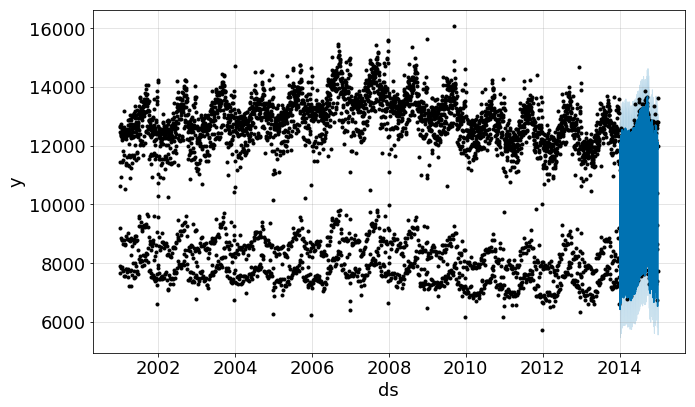

In [30]:
m.plot(forecast);

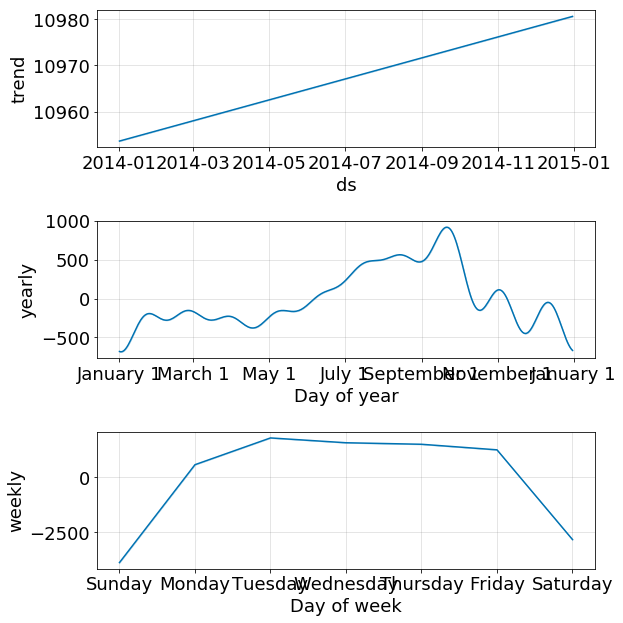

In [31]:
m.plot_components(forecast);
